# KL(q||p) = sum(q(x)log(q(x)/p(x))
let x be the hidden image and y be the visible image

C:\Users\micha\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


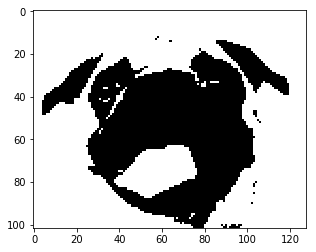

In [130]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

from scipy.misc import imread

originalImage = imread('pug.png')
originalImage = originalImage/255
fig = plt.figure
plt.imshow(originalImage, cmap='gray')

In [131]:
def add_gaussian_noise(im,prop,varSigma):
    N = int(np.round(np.prod(im.shape)*prop))
    
    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
    e = varSigma*np.random.randn(np.prod(im.shape)).reshape(im.shape)
    im2 = np.copy(im)
    im2[index] += e[index]
    
    return im2
def add_saltnpepper_noise(im,prop):
    N = int(np.round(np.prod(im.shape)*prop))
    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
    im2 = np.copy(im)
    im2[index] = 1 - im2[index]
    
    return im2

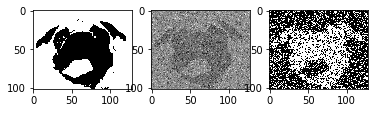

In [183]:
prop = 0.75
varSigma = 1

gaussImage = add_gaussian_noise(originalImage,prop,varSigma)
saltyImage = add_saltnpepper_noise(originalImage,prop)

threeFigs = plt.figure()
ax = threeFigs.add_subplot(131)
ax.imshow(originalImage, cmap = 'gray')

ax2 = threeFigs.add_subplot(132)
ax2.imshow(gaussImage, cmap = 'gray')
ax3 = threeFigs.add_subplot(133)
ax3.imshow(saltyImage, cmap = 'gray')

In [133]:
def neighbours(i,j,M,N,size=4):
    # Can expand to size = 8 if i fancy for better results :)
    if size == 4:
        if (i == 0 and j == 0):
            n = [(0,1),(1,0)]
        elif i == 0 and j == N-1:
            n = [(0,N-2),(1,N-1)]
        elif i == M-1 and j == 0:
            n = [(M-1,1),(M-2,0)]
        elif i == M-1 and j == N-1:
            n = [(M-1,N-2),(M-2,N-1)]
        elif i == 0:
            n = [(0,j-1),(0,j+1),(1,j)]
        elif i == M-1:
            n = [(M-1,j-1),(M-1,j+1),(M-2,j)]
        elif j == 0:
            n = [(i-1,0),(i+1,0),(i,1)]
        elif j == N-1:
            n = [(i-1,N-1),(i+1,N-1),(i,N-2)]
        else:
            n = [(i-1,j),(i+1,j),(i,j-1),(i,j+1)]
            
        return n
    elif size == 8:
        if (i == 0 and j == 0):
            n = [(0,1),(1,1),(1,0)]
        elif i == 0 and j == N-1:
            n = [(0,N-2),(1,N-1),(1,N-1)]
        elif i == M-1 and j ==0:
            n = [(M-1,1),(M-2,1),(M-2,0)]
        elif i == M-1 and j == N-1:
            n = [(M-1,N-2),(M-2,N-2),(M-2,N-1)]
        elif i == 0:
            n = [(0,j-1),(1,j-1),(0,j+1),(1,j+1),(1,j)]
        elif i == M-1:
            n = [(M-1,j-1),(M-2,j-1),(M-1,j+1),(M-2,j+1),(M-2,j)]
        elif j == 0:
            n = [(i-1,0),(i-1,1),(i+1,0),(i+1,1),(i,1)]
        elif j == N-1:
            n = [(i-1,N-1),(i-1,N-2),(i+1,N-1),(i+1,N-2),(i,N-2)]
        else:
            n = [(i-1,j),(i-1,j-1),(i+1,j),(i+1,j+1),(i,j-1),(i+1,j-1),(i,j+1),(i-1,j+1)]
             
        return n  

[0.4989224  0.96402758 0.987308   ... 0.99710199 0.96402758 0.99359462]
[102, 128]


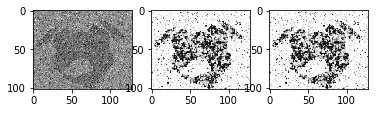

In [197]:
#ELBO = expected (log(p(x,y))) - expected(log(q(x)))
def sigmoid(x):
    output = 1/(1+np.exp(x))
    return output



NoiseyImage = np.copy(gaussImage)
rate = 1
maxIters = 10
flatNoise = NoiseyImage.flatten()
#flatNoise = flatNoise*100

Lpos = multivariate_normal.logpdf(flatNoise, 1, varSigma**2)
Lneg = multivariate_normal.logpdf(flatNoise,-1, varSigma**2)

logodds = Lpos - Lneg
w = 0.3
#mu = sigmoid(logodds)
#mu = 2*mu-1 # returns values between 1 and -1

#logodds = np.reshape(logodds, [len(logodds),1]) 
mu = np.tanh(logodds)

#print("logodds:",logodds)
#print("mu:",mu[0:100])
print(mu)
altmu = mu
[M,N] = NoiseyImage.shape
print([M,N])
for iter in range(maxIters):   
    for j in range(M):
        for i in range(N):
            index = i + N*j
            #print(index)
            Neighbours = neighbours(i,j,N,M,4)
            indexOfNs = []
            for dude in Neighbours:
                indexOfNs.append(dude[0] + N*dude[1])
            #print([index,indexOfNs])
            mi = mu[indexOfNs]
            #print(mi)
            m = sum(mu[indexOfNs]*w)
            #print(m)
            mu[index] = math.tanh(m + 0.5*logodds[index])
            
            mi2 = altmu[indexOfNs]
            m2 = sum(altmu[indexOfNs]*w)
            altmu[index] = (1-rate)*altmu[index] + rate*math.tanh(m2 + 0.5*logodds[index])
    #print(mu)
    a = mu + 0.5 * logodds
    qxp1 = sigmoid(2*a)
    qxm1 = sigmoid(-2*a)
    
mu = np.reshape(mu, [M, N])
altmu = np.reshape(altmu, [M,N])

twoFigs = plt.figure()

ax0 = twoFigs.add_subplot(131)
ax0.imshow(NoiseyImage, cmap = 'gray')

ax = twoFigs.add_subplot(132)
ax.imshow(mu, cmap = 'gray')

ax2 = twoFigs.add_subplot(133)
ax2.imshow(altmu, cmap = 'gray')



In [196]:
#ELBO = expected (log(p(x,y))) - expected(log(q(x)))
def sigmoid(x):
    output = 1/(1+np.exp(x))
    return output



NoiseyImage = np.copy(gaussImage)
flatNoise = NoiseyImage.flatten()
#flatNoise = flatNoise*100
[M,N] = NoiseyImage.shape
Lpos = multivariate_normal.logpdf(flatNoise, mean = 1, cov = varSigma**2)
Lneg = multivariate_normal.logpdf(flatNoise, mean =-1, cov = varSigma**2)

logodds = Lpos - Lneg
logodds = np.reshape(logodds,(M,N))


rate = 1
maxIters = 10
w = 0.3
mu = sigmoid(logodds)
mu = 2*mu-1 # returns values between 1 and -1
m = mu+0.5*logodds

qxp1 = sigmoid(2*a)
qxm1 = sigmoid(-2*a)

logp1 = np.reshape(Lpos,(M,N))
logm1 = np.reshape(Lneg,(M,N))

ELBO = np.zeros([maxIters,1])
Hx_mean = np.zeros([maxIters,1])


print([M,N])
for iter in range(maxIters): 
    muNew = mu
    print(muNew.shape)
    print(ELBO.shape)
    for x in range(N):
        for y in range(M):
            index = y + M*x
            #print(index)
            Neighbours = neighbours(i,j,N,M,4)
            indexOfNs = []
            for dude in Neighbours:
                indexOfNs.append(dude[0] + N*dude[1])

            xx, yy = np.unravel_index(index, (M,N), order='F')
            NofX, NofY = np.unravel_index(Neighbours, (M,N), order = 'F')
            M = w*np.sum(mu[NofX,NofY])
            muNew[xx,yy] = np.tanh(M + logodds[xx,yy])
            ELBO[iter] = ELBO[iter] + 0.5*M*muNew[xx,yy]
            
            
    mu = muNew
    a = mu + 0.5 * logodds
    qxp1 = sigmoid(2*a)
    qxm1 = sigmoid(-2*a)
    Hx = -qxm1*np.log(qxm1+1e-10) - qxp1*np.log(qxp1+1e-10)
    ELBO[i] = ELBO[i] + np.sum(qxp1*logp1 + qxm1*logm1) + np.sum(Hx)
    Hx_mean[i] = np.mean(Hx)
    
mu = np.reshape(mu, [M, N])
altmu = np.reshape(altmu, [M,N])

twoFigs = plt.figure()

ax0 = twoFigs.add_subplot(131)
ax0.imshow(NoiseyImage, cmap = 'gray')

ax = twoFigs.add_subplot(132)
ax.imshow(mu, cmap = 'gray')

ax2 = twoFigs.add_subplot(133)
ax2.imshow(altmu, cmap = 'gray')



[102, 128]
(102, 128)
(10, 1)


TypeError: 'numpy.float64' object cannot be interpreted as an integer